In [43]:
from torchvision.utils import *
from torch.utils.data import *
from torchvision import datasets, transforms

import torchvision
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt

import copy

device = 'cpu' # or cuda

In [44]:
import numpy as np

def showimg(img):
#     img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [45]:
tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
   # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
])

ds_content = datasets.ImageFolder(root='data/real', transform=tf)
ds_style = datasets.ImageFolder(root='data/anime',transform=tf)
content = DataLoader(ds_content, batch_size=1)
style = DataLoader(ds_style, batch_size=1)

In [46]:
ds_c = iter(content)
ds_s = iter(style)

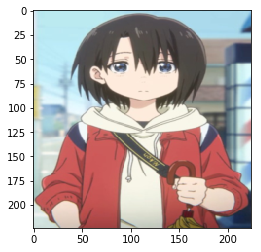

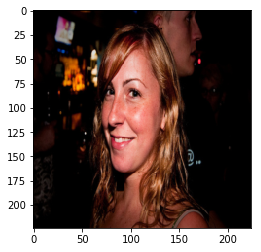

In [47]:
# a bit ugly :)
content_img = next(ds_c)
style_img = next(ds_s)

showimg(style_img[0].squeeze())
showimg(content_img[0].squeeze())

In [48]:
def calc_2_moments(tensor):
    tensor = tensor.squeeze()
    c, h, w = tensor.shape
    n = h * w    
    flat_array = tensor.view(c, n)
    
    mu = flat_array.mean(dim=1).reshape(c, -1)
    cov = torch.sub(flat_array, mu)
    cov = torch.div(torch.matmul(cov, cov.t()), n)    
    
    return mu, cov

In [49]:
# thanks to karl 
# https://github.com/kheyer/ML-DL-Projects/blob/master/Wasserstein%20Texture%20Synthesis/Wasserstein%20Texture%20Synthesis.ipynb
def get_style_vals(tensor):
    mean, cov = calc_2_moments(tensor)
    eigvals, eigvects = torch.symeig(cov, eigenvectors=True)
    eigroot_mat = torch.diag(torch.sqrt(eigvals.clamp(min=0)))
    root_cov = torch.mm(torch.mm(eigvects, eigroot_mat), eigvects.t())
    tr_cov = eigvals.clamp(min=0).sum()
    return mean, tr_cov, root_cov

def calc_l2wass_dist(mean_stl, tr_cov_stl, root_cov_stl, mean_synth, cov_synth):
    tr_cov_synth = torch.symeig(cov_synth, eigenvectors=True)[0].clamp(min=0).sum()
    mean_diff_squared = (mean_stl - mean_synth).pow(2).sum()
    cov_prod = torch.mm(torch.mm(root_cov_stl, cov_synth), root_cov_stl)
    var_overlap = torch.sqrt(torch.symeig(cov_prod, eigenvectors=True)[0].clamp(min=0)+1e-8).sum()
    dist = mean_diff_squared + tr_cov_stl + tr_cov_synth - 2*var_overlap
    return dist

def single_wass_loss(pred, targ):
    mean_test, tr_cov_test, root_cov_test = get_style_vals(targ)
    mean_synth, cov_synth = calc_2_moments(pred)
    loss = calc_l2wass_dist(mean_test, tr_cov_test, root_cov_test, mean_synth, cov_synth)
    return loss

In [50]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        # style transfer can happen after each conv2d layer
#         i = 0
#         for layer in cnn.children():    
#             if(isinstance(layer, nn.Conv2d)):
#                 print(i)
#             i = i + 1 //this can be a layer after max pool in the conv layer
        self.select = ['0', '5', '10', '19', '28']
        self.vgg = models.vgg19(pretrained=True).features
        
    def forward(self, x):
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features

Step [100/2000], Content Loss: 9.4328, Style Loss: 921.7606


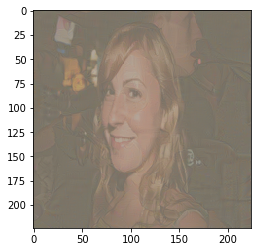

KeyboardInterrupt: 

In [52]:
style_weight = 100

content = content_img[0]
style = style_img[0]
target = content_img[0].clone().requires_grad_(True)

optimizer = torch.optim.Adam([target], lr = 0.002, betas=[0.5, 0.999])
vgg = VGGNet().to(device).eval()

steps = 2000

for step in range(steps):
    
    #extract features for all 5 layers (Conv2D) selected in VGGNET after each MaxPoollayer
    target_features = vgg(target.to(device))
    content_features = vgg(content.to(device))
    style_features = vgg(style.to(device))
    
    
    style_loss = 0
    content_loss = 0
    lm = 0
    for f1, f2, f3 in zip(target_features, content_features, style_features):
        # compute content loss
        content_loss += torch.mean((f1 - f2)**2)
        
#         lm = lm + 1
        # get gram matrix
#         f1 = gram_matrix(f1)
#         f3 = gram_matrix(f3)
        
        # compute style loss
#         style_loss += torch.mean(((f1 - f3)**2))
        style_loss += single_wass_loss(f1, f3)
    # total loss with style weight default is 100
    loss = content_loss + style_weight * style_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (step+1) % 100 == 0:
        print ('Step [{}/{}], Content Loss: {:.4f}, Style Loss: {:.4f}' 
               .format(step+1, steps, content_loss.item(), style_loss.item()))

        # Save the generated image
        denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
        img = target.clone().squeeze()
        img = denorm(img).clamp_(0, 1)
        
        showimg(img.data)
    

# torchvision.utils.save_image(img, 'output-_gram_matrix_{}.png'.format(step+1))
    